In [106]:
%matplotlib inline
import sys
sys.path.insert(1, '../../../script/')
import math
import collections
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
#import missingno as msno

from collections import defaultdict
from scipy.stats.stats import pearsonr

from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import plot_confusion_matrix

import pydotplus
from sklearn import tree
from IPython.display import Image

import cleaning_classification as cl
import cleaning_test as cl_test
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [107]:
def report(results, n_top=3):
    configurations = {}
    c_i = 0
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean training score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_train_score'][candidate],
                  results['std_train_score'][candidate]))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            configurations[c_i] = results['params'][candidate]
            c_i += 1 
    return configurations

def report_multiple(results, n_top=3, scoring = 'roc_auc'):
    configurations = {}
    c_i = 0
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_' + scoring] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean training score:", end = '')
            print("   roc_auc: {0:.3f} (std: {1:.3f})".format(
                  results['mean_train_roc_auc'][candidate],
                  results['std_train_roc_auc'][candidate]), end = '')
            print(", Accuracy: {0:.3f} (std: {1:.3f})".format(
                  results['mean_train_accuracy'][candidate],
                  results['std_train_accuracy'][candidate]), end = '')
            print(", f1: {0:.3f} (std: {1:.3f})".format(
                  results['mean_train_f1'][candidate],
                  results['std_train_f1'][candidate]))


            print("Mean validation score:", end = '')
            print(" roc_auc: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_roc_auc'][candidate],
                  results['std_test_roc_auc'][candidate]), end = '')
            print(", Accuracy: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_accuracy'][candidate],
                  results['std_test_accuracy'][candidate]), end = '')
            print(", f1: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_f1'][candidate],
                  results['std_test_f1'][candidate]))

            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            configurations[c_i] = results['params'][candidate]
            c_i += 1 
    return configurations

# feature relevant

In [108]:
df = pd.read_csv('../../data/training.csv') 
cl.cleaning(df)
df.columns
df.isnull().sum()

IsBadBuy                             0
Auction                              0
VehicleAge                           0
WheelTypeID                          0
VehOdo                               0
Size                                 0
MMRAcquisitionAuctionAveragePrice    0
VNST                                 0
VehBCost                             0
WarrantyCost                         0
dtype: int64

In [109]:
df = pd.get_dummies(df)
df = pd.get_dummies(df, columns=['WheelTypeID'])
df.columns


Index(['IsBadBuy', 'VehicleAge', 'VehOdo', 'MMRAcquisitionAuctionAveragePrice',
       'VehBCost', 'WarrantyCost', 'Auction_ADESA', 'Auction_MANHEIM',
       'Auction_OTHER', 'Size_COMPACT', 'Size_CROSSOVER', 'Size_LARGE',
       'Size_LARGE SUV', 'Size_LARGE TRUCK', 'Size_MEDIUM', 'Size_MEDIUM SUV',
       'Size_SMALL SUV', 'Size_SMALL TRUCK', 'Size_SPECIALTY', 'Size_SPORTS',
       'Size_VAN', 'VNST_AL', 'VNST_AR', 'VNST_AZ', 'VNST_CA', 'VNST_CO',
       'VNST_FL', 'VNST_GA', 'VNST_IA', 'VNST_ID', 'VNST_IL', 'VNST_IN',
       'VNST_KY', 'VNST_LA', 'VNST_MA', 'VNST_MD', 'VNST_MI', 'VNST_MN',
       'VNST_MO', 'VNST_MS', 'VNST_NC', 'VNST_NE', 'VNST_NH', 'VNST_NJ',
       'VNST_NM', 'VNST_NV', 'VNST_NY', 'VNST_OH', 'VNST_OK', 'VNST_OR',
       'VNST_PA', 'VNST_SC', 'VNST_TN', 'VNST_TX', 'VNST_UT', 'VNST_VA',
       'VNST_WA', 'VNST_WV', 'WheelTypeID_1.0', 'WheelTypeID_2.0',
       'WheelTypeID_3.0'],
      dtype='object')

In [110]:
attributes = [col for col in df.columns if col != 'IsBadBuy']
x = df[attributes].values
y = df['IsBadBuy']

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3, stratify=y)

In [111]:
param_list = {'criterion': ['gini', 'entropy'],
              'max_depth': [None] + list(np.arange(2, 10)),
              'min_samples_split': list(np.arange(2, 40)),
              'min_samples_leaf': list(np.arange(1, 40)),
             }
new_params = {'decisiontreeclassifier__' + key: param_list[key] for key in param_list}

skf = StratifiedKFold(n_splits=3)
clf = DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1)
imba_pipeline = make_pipeline(RandomUnderSampler(), clf)
scoring = ['accuracy', 'f1', 'roc_auc' ]

random_search = RandomizedSearchCV(imba_pipeline, param_distributions=new_params, n_iter=4000, cv=skf, scoring=scoring, refit = 'roc_auc', n_jobs = 4, verbose = 1, return_train_score=True)
random_search.fit(x_train, y_train)
cnfs = report_multiple(random_search.cv_results_, n_top=3, scoring = 'roc_auc')

Fitting 3 folds for each of 4000 candidates, totalling 12000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:   10.3s
[Parallel(n_jobs=4)]: Done 876 tasks      | elapsed:   23.7s
[Parallel(n_jobs=4)]: Done 1576 tasks      | elapsed:   42.4s
[Parallel(n_jobs=4)]: Done 2476 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 3576 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 4876 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done 6376 tasks      | elapsed:  2.9min
[Parallel(n_jobs=4)]: Done 8076 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 9976 tasks      | elapsed:  4.5min


Model with rank: 1
Mean training score:   roc_auc: 0.675 (std: 0.002), Accuracy: 0.582 (std: 0.024), f1: 0.281 (std: 0.003)
Mean validation score: roc_auc: 0.671 (std: 0.005), Accuracy: 0.581 (std: 0.026), f1: 0.280 (std: 0.002)
Parameters: {'decisiontreeclassifier__min_samples_split': 8, 'decisiontreeclassifier__min_samples_leaf': 23, 'decisiontreeclassifier__max_depth': 5, 'decisiontreeclassifier__criterion': 'gini'}

Model with rank: 2
Mean training score:   roc_auc: 0.678 (std: 0.005), Accuracy: 0.578 (std: 0.031), f1: 0.283 (std: 0.002)
Mean validation score: roc_auc: 0.671 (std: 0.007), Accuracy: 0.577 (std: 0.036), f1: 0.280 (std: 0.009)
Parameters: {'decisiontreeclassifier__min_samples_split': 37, 'decisiontreeclassifier__min_samples_leaf': 9, 'decisiontreeclassifier__max_depth': 6, 'decisiontreeclassifier__criterion': 'entropy'}

Model with rank: 3
Mean training score:   roc_auc: 0.681 (std: 0.004), Accuracy: 0.579 (std: 0.073), f1: 0.282 (std: 0.004)
Mean validation score: ro

[Parallel(n_jobs=4)]: Done 12000 out of 12000 | elapsed:  5.4min finished


In [112]:
rus = RandomUnderSampler()
x_u_train_resampled, y_u_train_resampled = rus.fit_resample(x_train, y_train)

In [113]:
models_u = []
y_pred_vals_u = []
y_pred_trains_u = []
hyper_ps = random_search.cv_results_
for cnf in cnfs.values():
    criterion = cnf['decisiontreeclassifier__criterion']
    max_depth = cnf['decisiontreeclassifier__max_depth']
    min_samples_split = cnf['decisiontreeclassifier__min_samples_split']
    min_samples_leaf = cnf['decisiontreeclassifier__min_samples_leaf']
    clf = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
    clf = clf.fit(x_u_train_resampled, y_u_train_resampled)
    models_u.append(clf)
    y_pred = clf.predict(x_val)
    y_pred_tr = clf.predict(x_u_train_resampled)
    y_pred_vals_u.append(y_pred)
    y_pred_trains_u.append(y_pred_tr)   

In [114]:
for col, imp in zip(attributes, models_u[0].feature_importances_):
    print(col, imp)

VehicleAge 0.7959615043532399
VehOdo 0.013607378165002336
MMRAcquisitionAuctionAveragePrice 0.028269481782615773
VehBCost 0.1032056444534923
WarrantyCost 0.025918600183515036
Auction_ADESA 0.0019607460713006683
Auction_MANHEIM 0.01012144290951909
Auction_OTHER 0.0
Size_COMPACT 0.012398918358315712
Size_CROSSOVER 0.0
Size_LARGE 0.0
Size_LARGE SUV 0.0
Size_LARGE TRUCK 0.0
Size_MEDIUM 0.0
Size_MEDIUM SUV 0.0
Size_SMALL SUV 0.0
Size_SMALL TRUCK 0.0
Size_SPECIALTY 0.0
Size_SPORTS 0.0
Size_VAN 0.0
VNST_AL 0.0
VNST_AR 0.0
VNST_AZ 0.0
VNST_CA 0.0
VNST_CO 0.0
VNST_FL 0.008556283722999027
VNST_GA 0.0
VNST_IA 0.0
VNST_ID 0.0
VNST_IL 0.0
VNST_IN 0.0
VNST_KY 0.0
VNST_LA 0.0
VNST_MA 0.0
VNST_MD 0.0
VNST_MI 0.0
VNST_MN 0.0
VNST_MO 0.0
VNST_MS 0.0
VNST_NC 0.0
VNST_NE 0.0
VNST_NH 0.0
VNST_NJ 0.0
VNST_NM 0.0
VNST_NV 0.0
VNST_NY 0.0
VNST_OH 0.0
VNST_OK 0.0
VNST_OR 0.0
VNST_PA 0.0
VNST_SC 0.0
VNST_TN 0.0
VNST_TX 0.0
VNST_UT 0.0
VNST_VA 0.0
VNST_WA 0.0
VNST_WV 0.0
WheelTypeID_1.0 0.0
WheelTypeID_2.0 0.0
Wh

# Check the feature used for classification

ne ho selezionate solo alcune, speravo cambiasse qualcosa, possiamo scrivere che dopo diversi test sul decision tree ci siamo resi conto che queste hanno più importanza rispetto alle altre, le abbiamo selezionate per essere sicuri di non andare ada incorrere nella curse of dimensionality

In [187]:
df = pd.read_csv('../../data/training.csv') 
cl.cleaning(df)
df.columns

Index(['IsBadBuy', 'Auction', 'VehicleAge', 'WheelTypeID', 'VehOdo', 'Size',
       'MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionRetailAveragePrice',
       'MMRCurrentAuctionAveragePrice', 'MMRCurrentRetailAveragePrice', 'VNST',
       'VehBCost', 'WarrantyCost'],
      dtype='object')

In [188]:
df = pd.get_dummies(df)
df = pd.get_dummies(df, columns=['WheelTypeID'])
df.columns

Index(['IsBadBuy', 'VehicleAge', 'VehOdo', 'MMRAcquisitionAuctionAveragePrice',
       'MMRAcquisitionRetailAveragePrice', 'MMRCurrentAuctionAveragePrice',
       'MMRCurrentRetailAveragePrice', 'VehBCost', 'WarrantyCost',
       'Auction_ADESA', 'Auction_MANHEIM', 'Auction_OTHER', 'Size_COMPACT',
       'Size_CROSSOVER', 'Size_LARGE', 'Size_LARGE SUV', 'Size_LARGE TRUCK',
       'Size_MEDIUM', 'Size_MEDIUM SUV', 'Size_SMALL SUV', 'Size_SMALL TRUCK',
       'Size_SPECIALTY', 'Size_SPORTS', 'Size_VAN', 'VNST_AL', 'VNST_AR',
       'VNST_AZ', 'VNST_CA', 'VNST_CO', 'VNST_FL', 'VNST_GA', 'VNST_IA',
       'VNST_ID', 'VNST_IL', 'VNST_IN', 'VNST_KY', 'VNST_LA', 'VNST_MA',
       'VNST_MD', 'VNST_MI', 'VNST_MN', 'VNST_MO', 'VNST_MS', 'VNST_NC',
       'VNST_NE', 'VNST_NH', 'VNST_NJ', 'VNST_NM', 'VNST_NV', 'VNST_NY',
       'VNST_OH', 'VNST_OK', 'VNST_OR', 'VNST_PA', 'VNST_SC', 'VNST_TN',
       'VNST_TX', 'VNST_UT', 'VNST_VA', 'VNST_WA', 'VNST_WV',
       'WheelTypeID_1.0', 'WheelTypeID_2.0',

# Split in train and validation

validation condiviso con le varie tecniche per il confronto, fatto con lo stratified per tenere tutto bilanciato con le classi.

In [189]:
attributes = [col for col in df.columns if col != 'IsBadBuy']
x = df[attributes].values
y = df['IsBadBuy']

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3, stratify=y)

# - Undersampling
uso from RandomUnderSampler: 
https://imbalanced-learn.readthedocs.io/en/stable/under_sampling.html

### GRIDSEARCH

In [199]:
param_list = {'criterion': ['gini', 'entropy'],
              'max_depth': [None] + list(np.arange(2, 10)),
              'min_samples_split': list(np.arange(2, 40)),
              'min_samples_leaf': list(np.arange(1, 40)),
             }
new_params = {'decisiontreeclassifier__' + key: param_list[key] for key in param_list}

skf = StratifiedKFold(n_splits=3)
clf = DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1)
imba_pipeline = make_pipeline(RandomUnderSampler(), clf)
scoring = ['accuracy', 'f1', 'roc_auc' ]

random_search = RandomizedSearchCV(imba_pipeline, param_distributions=new_params, n_iter=1000, cv=skf, scoring=scoring, refit = 'roc_auc', n_jobs = 4, verbose = 1, return_train_score=True)
random_search.fit(x_train, y_train)
cnfs = report_multiple(random_search.cv_results_, n_top=3, scoring = 'roc_auc')

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:   13.1s
[Parallel(n_jobs=4)]: Done 876 tasks      | elapsed:   30.0s
[Parallel(n_jobs=4)]: Done 1576 tasks      | elapsed:   53.6s
[Parallel(n_jobs=4)]: Done 2476 tasks      | elapsed:  1.4min


Model with rank: 1
Mean training score:   roc_auc: 0.678 (std: 0.004), Accuracy: 0.565 (std: 0.034), f1: 0.282 (std: 0.002)
Mean validation score: roc_auc: 0.668 (std: 0.006), Accuracy: 0.563 (std: 0.033), f1: 0.278 (std: 0.008)
Parameters: {'decisiontreeclassifier__min_samples_split': 26, 'decisiontreeclassifier__min_samples_leaf': 25, 'decisiontreeclassifier__max_depth': 5, 'decisiontreeclassifier__criterion': 'gini'}

Model with rank: 2
Mean training score:   roc_auc: 0.676 (std: 0.002), Accuracy: 0.588 (std: 0.017), f1: 0.281 (std: 0.001)
Mean validation score: roc_auc: 0.668 (std: 0.003), Accuracy: 0.585 (std: 0.025), f1: 0.278 (std: 0.000)
Parameters: {'decisiontreeclassifier__min_samples_split': 22, 'decisiontreeclassifier__min_samples_leaf': 31, 'decisiontreeclassifier__max_depth': 5, 'decisiontreeclassifier__criterion': 'entropy'}

Model with rank: 3
Mean training score:   roc_auc: 0.677 (std: 0.002), Accuracy: 0.595 (std: 0.039), f1: 0.286 (std: 0.004)
Mean validation score: 

[Parallel(n_jobs=4)]: Done 3000 out of 3000 | elapsed:  1.7min finished


### Perform Clustering

In [200]:
rus = RandomUnderSampler()
x_u_train_resampled, y_u_train_resampled = rus.fit_resample(x_train, y_train)

In [201]:
models_u = []
y_pred_vals_u = []
y_pred_trains_u = []
hyper_ps = random_search.cv_results_
for cnf in cnfs.values():
    criterion = cnf['decisiontreeclassifier__criterion']
    max_depth = cnf['decisiontreeclassifier__max_depth']
    min_samples_split = cnf['decisiontreeclassifier__min_samples_split']
    min_samples_leaf = cnf['decisiontreeclassifier__min_samples_leaf']
    clf = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
    clf = clf.fit(x_u_train_resampled, y_u_train_resampled)
    models_u.append(clf)
    y_pred = clf.predict(x_val)
    y_pred_tr = clf.predict(x_u_train_resampled)
    y_pred_vals_u.append(y_pred)
    y_pred_trains_u.append(y_pred_tr)   

### Analyze the classification results

In [249]:
roc_auc_models_u_val = []
for i in range(0,len(cnfs)):
    print("model {}".format(i))
    print('Train Accuracy %s' % accuracy_score(y_u_train_resampled, y_pred_trains_u[i]))
    print('Train F1-score %s' % f1_score(y_u_train_resampled, y_pred_trains_u[i], average=None))

    fpr, tpr, _ = roc_curve(y_u_train_resampled, y_pred_trains_u[i])
    roc_auc = auc(fpr, tpr)
    roc_auc = roc_auc_score(y_u_train_resampled, y_pred_trains_u[i], average=None)
    print("Train roc_auc: {}".format(roc_auc))
    print()
    
    print('Test Accuracy %s' % accuracy_score(y_val, y_pred_vals_u[i]))
    print('Test F1-score %s' % f1_score(y_val, y_pred_vals_u[i], average=None))
    
    fpr, tpr, _ = roc_curve(y_val, y_pred_vals[i])
    roc_auc = auc(fpr, tpr)
    roc_auc = roc_auc_score(y_val, y_pred_vals[i], average=None)
    print("Test roc_auc: {}".format(roc_auc))
    roc_auc_models_u_val.append(roc_auc)
 
    print(classification_report(y_val, y_pred_vals_u[i]))
    print(confusion_matrix(y_val, y_pred_vals_u[i]))

model 0
Train Accuracy 0.6295503211991434
Train F1-score [0.6119336  0.64563703]
Train roc_auc: 0.6295503211991434

Test Accuracy 0.5887634995752943
Test F1-score [0.71157447 0.28381234]
Test roc_auc: 0.6268492557166591
              precision    recall  f1-score   support

           0       0.93      0.58      0.71     14480
           1       0.18      0.67      0.28      2002

    accuracy                           0.59     16482
   macro avg       0.55      0.62      0.50     16482
weighted avg       0.84      0.59      0.66     16482

[[8361 6119]
 [ 659 1343]]
model 1
Train Accuracy 0.6285867237687366
Train F1-score [0.60983017 0.64562264]
Train roc_auc: 0.6285867237687366

Test Accuracy 0.5858512316466449
Test F1-score [0.70886292 0.28283253]
Test roc_auc: 0.625924972817238
              precision    recall  f1-score   support

           0       0.93      0.57      0.71     14480
           1       0.18      0.67      0.28      2002

    accuracy                           0.59

In [250]:
for i in range(0,len(cnfs)):
    print("model {} - roc_auc: {}".format(i, roc_auc_models_u_val[i]))

model 0 - roc_auc: 0.6268492557166591
model 1 - roc_auc: 0.625924972817238
model 2 - roc_auc: 0.6263048070713817


### Choose the best model

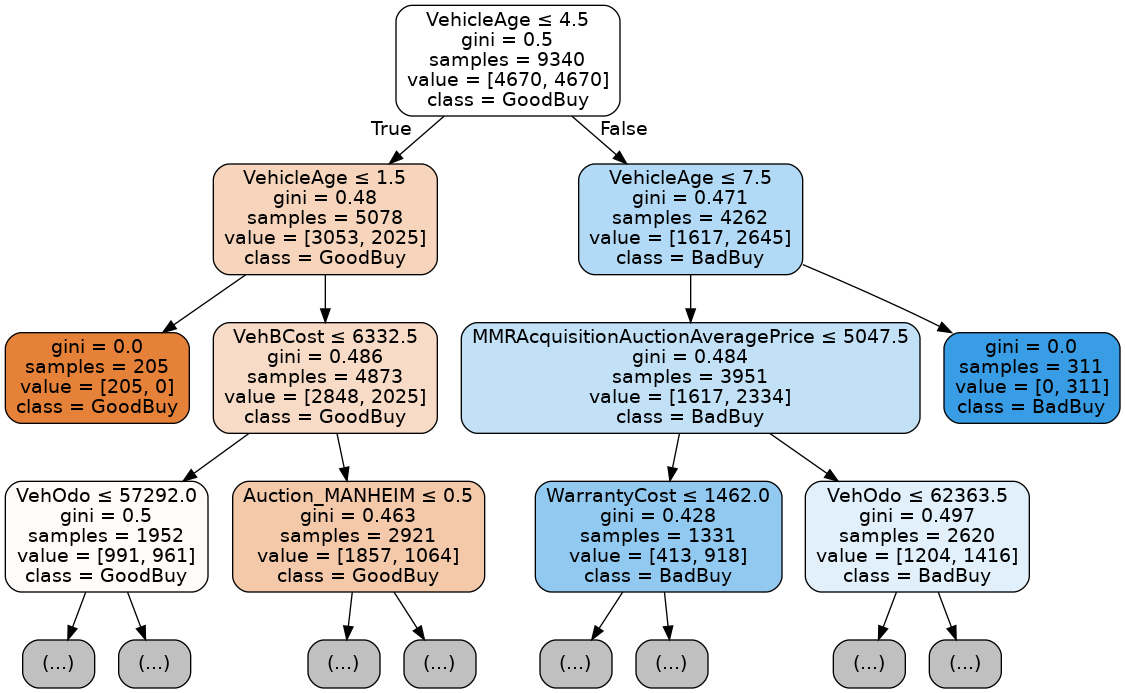

In [258]:
dot_data = tree.export_graphviz(models_u[0], out_file=None,
                                feature_names=attributes,
                                class_names=['BadBuy' if x == 1 else 'GoodBuy' for x in clf.classes_],  
                                filled=True, rounded=True,  
                                special_characters=True,
                                max_depth=3)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

Evaluate the performance

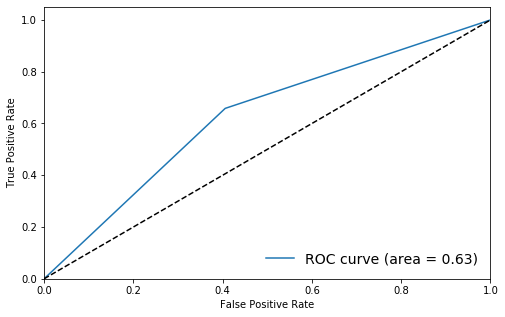

In [206]:
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc_models_u_val[0]))
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate') 
plt.tick_params(axis='both', which='major')
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.show()

# - Uppersampling
rimetto insieme x_train e y_train per poter aumentare i record della classe minoritaria (lo 1) uso SMOTE: 
https://imbalanced-learn.readthedocs.io/en/stable/over_sampling.html

### GRIDSEARCH

In [115]:
param_list = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None] + list(np.arange(2, 20)),
    'min_samples_split': list(np.arange(2, 40)),
    'min_samples_leaf': list(np.arange(2, 40)),
    'min_impurity_decrease': [0.75e-6, 0.5e-6, 1e-6]
    }
new_params = {'decisiontreeclassifier__' + key: param_list[key] for key in param_list}

skf = StratifiedKFold(n_splits=3)
clf = DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1)
imba_pipeline = make_pipeline(SMOTE(sampling_strategy= 1.0, random_state=42), clf)
scoring = ['accuracy', 'f1', 'roc_auc' ]

#grid_imba = RandomizedSearchCV(imba_pipeline, param_distributions=new_params, cv=skf, n_iter=400, return_train_score=True, scoring='f1', n_jobs = 4, verbose = 1)
grid_imba = RandomizedSearchCV(imba_pipeline, param_distributions=new_params, n_iter=1000, cv=skf, scoring=scoring, refit = 'roc_auc', n_jobs = 4, verbose = 1, return_train_score=True)


grid_imba.fit(x, y)
cnfs = report_multiple(grid_imba.cv_results_, n_top=3, scoring = 'roc_auc')

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   52.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:  5.8min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:  8.4min
[Parallel(n_jobs=4)]: Done 2442 tasks      | elapsed: 11.5min
[Parallel(n_jobs=4)]: Done 3000 out of 3000 | elapsed: 14.0min finished


Model with rank: 1
Mean training score:   roc_auc: 0.707 (std: 0.002), Accuracy: 0.880 (std: 0.005), f1: 0.195 (std: 0.033)
Mean validation score: roc_auc: 0.665 (std: 0.007), Accuracy: 0.876 (std: 0.008), f1: 0.173 (std: 0.023)
Parameters: {'decisiontreeclassifier__min_samples_split': 15, 'decisiontreeclassifier__min_samples_leaf': 2, 'decisiontreeclassifier__min_impurity_decrease': 7.5e-07, 'decisiontreeclassifier__max_depth': 10, 'decisiontreeclassifier__criterion': 'entropy'}

Model with rank: 2
Mean training score:   roc_auc: 0.707 (std: 0.002), Accuracy: 0.880 (std: 0.005), f1: 0.195 (std: 0.033)
Mean validation score: roc_auc: 0.665 (std: 0.007), Accuracy: 0.876 (std: 0.008), f1: 0.173 (std: 0.023)
Parameters: {'decisiontreeclassifier__min_samples_split': 14, 'decisiontreeclassifier__min_samples_leaf': 2, 'decisiontreeclassifier__min_impurity_decrease': 5e-07, 'decisiontreeclassifier__max_depth': 10, 'decisiontreeclassifier__criterion': 'entropy'}

Model with rank: 3
Mean traini

### Perform Clustering

In [116]:
sm = SMOTE(sampling_strategy=1.0, random_state=42)
x_o_train_resampled, y_o_train_resampled = sm.fit_sample(x_train, y_train)

In [117]:
models_o = []
y_pred_vals_o = []
y_pred_trains_o = []
hyper_ps = grid_imba.cv_results_
for cnf in cnfs.values():
    criterion = cnf['decisiontreeclassifier__criterion']
    max_depth = cnf['decisiontreeclassifier__max_depth']
    min_samples_split = cnf['decisiontreeclassifier__min_samples_split']
    min_samples_leaf = cnf['decisiontreeclassifier__min_samples_leaf']
    clf = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
    clf = clf.fit(x_o_train_resampled, y_o_train_resampled)
    models_o.append(clf)
    y_pred = clf.predict(x_val)
    y_pred_tr = clf.predict(x_o_train_resampled)
    y_pred_vals_o.append(y_pred)
    y_pred_trains_o.append(y_pred_tr)   

In [118]:
roc_auc_models_o_val = []
for i in range(0,len(cnfs)):
    print("model {}".format(i))
    print('Train Accuracy %s' % accuracy_score(y_o_train_resampled, y_pred_trains_o[i]))
    print('Train F1-score %s' % f1_score(y_o_train_resampled, y_pred_trains_o[i], average=None))
    
    fpr, tpr, _ = roc_curve(y_o_train_resampled, y_pred_trains_o[i])
    roc_auc = auc(fpr, tpr)
    roc_auc = roc_auc_score(y_o_train_resampled, y_pred_trains_o[i], average=None)
    print("Train roc_auc: {}".format(roc_auc))
    print()

    print('Test Accuracy %s' % accuracy_score(y_val, y_pred_vals_o[i]))
    print('Test F1-score %s' % f1_score(y_val, y_pred_vals_o[i], average=None))

    fpr, tpr, _ = roc_curve(y_val, y_pred_vals_o[i])
    roc_auc = auc(fpr, tpr)
    roc_auc = roc_auc_score(y_val, y_pred_vals_o[i], average=None)
    print("Test roc_auc: {}".format(roc_auc))
    roc_auc_models_o_val.append(roc_auc)
    
    print(classification_report(y_val, y_pred_vals_o[i]))
    print(confusion_matrix(y_val, y_pred_vals_o[i]))

model 0
Train Accuracy 0.900738526463865
Train F1-score [0.90787684 0.89240104]
Train roc_auc: 0.900738526463865

Test Accuracy 0.8732055979338098
Test F1-score [0.93119072 0.19396716]
Test roc_auc: 0.5510889159150029
              precision    recall  f1-score   support

           0       0.89      0.98      0.93     14625
           1       0.43      0.13      0.19      2024

    accuracy                           0.87     16649
   macro avg       0.66      0.55      0.56     16649
weighted avg       0.83      0.87      0.84     16649

[[14284   341]
 [ 1770   254]]
model 1
Train Accuracy 0.900738526463865
Train F1-score [0.90787684 0.89240104]
Train roc_auc: 0.900738526463865

Test Accuracy 0.8733857889362725
Test F1-score [0.93129522 0.1941896 ]
Test roc_auc: 0.551191480017567
              precision    recall  f1-score   support

           0       0.89      0.98      0.93     14625
           1       0.43      0.13      0.19      2024

    accuracy                           0.87

### Analyze the classification performance

In [119]:
for i in range(0,len(cnfs)):
    print("model {} - roc_auc: {}".format(i, roc_auc_models_o_val[i]))

model 0 - roc_auc: 0.5510889159150029
model 1 - roc_auc: 0.551191480017567
model 2 - roc_auc: 0.5513624201885071


### Choose the best model

Visualize the decision tree

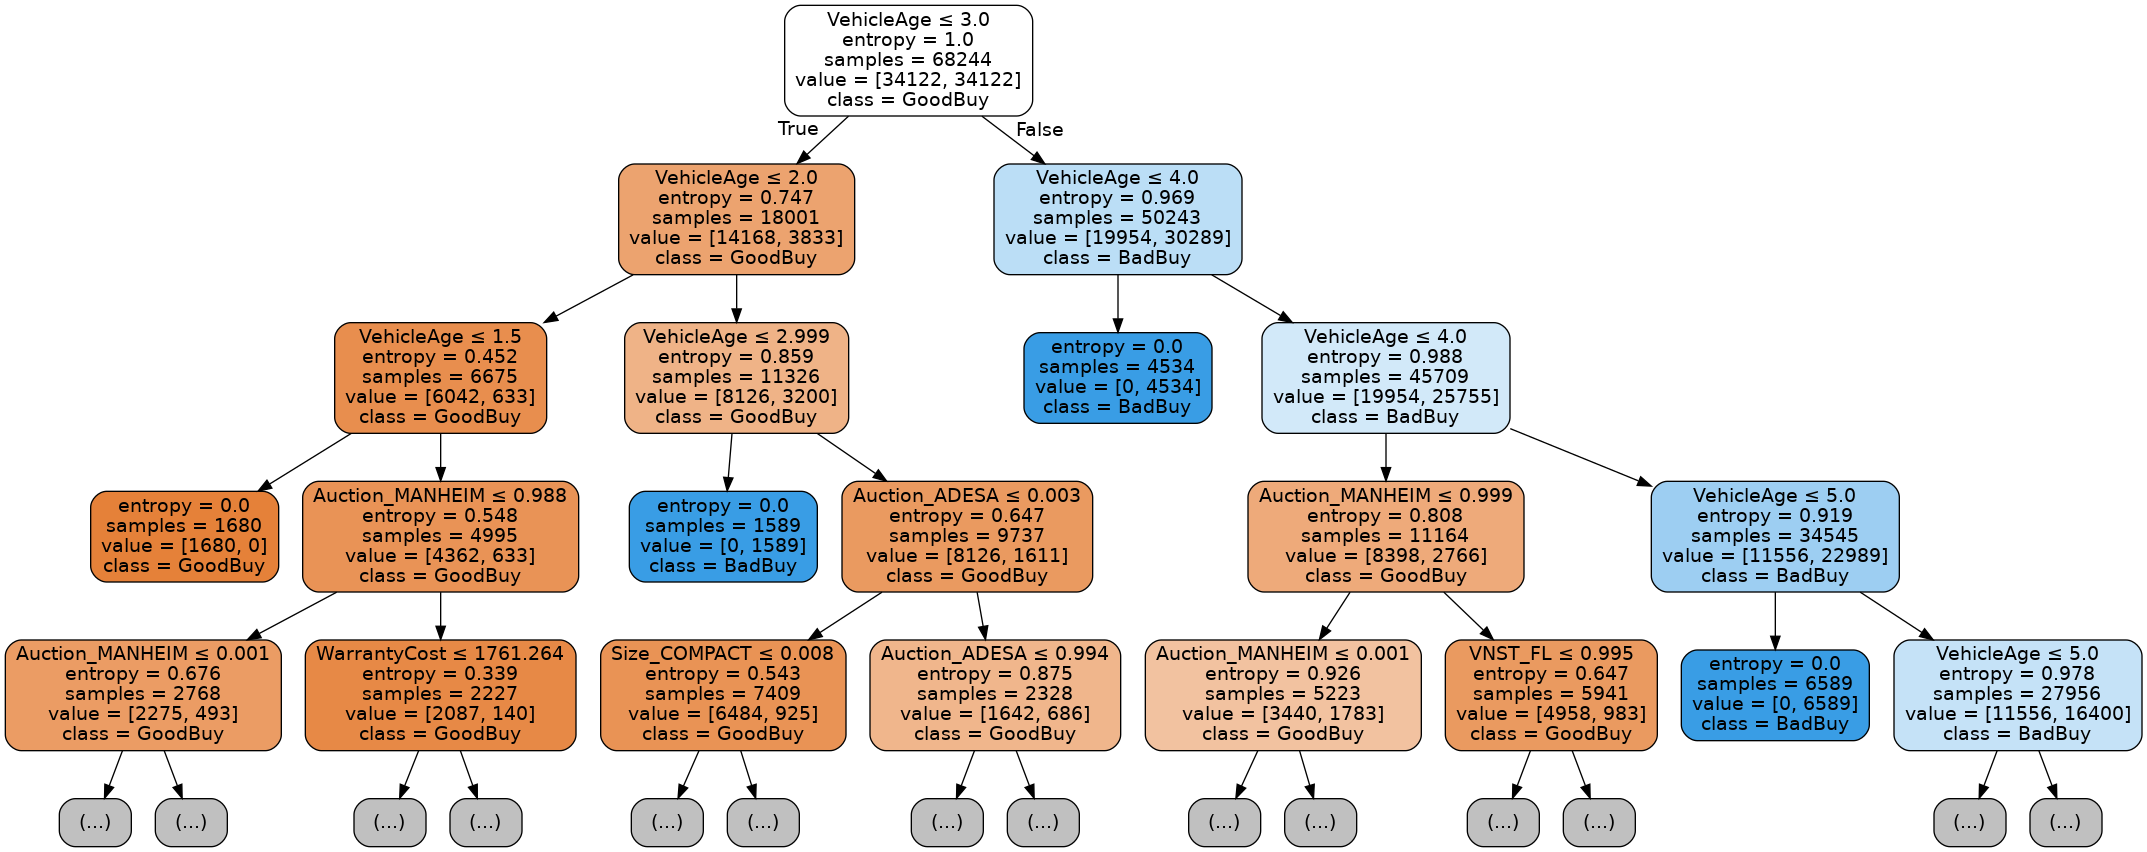

In [120]:
dot_data = tree.export_graphviz(models_o[2], out_file=None,
                                feature_names=attributes,
                                class_names=['BadBuy' if x == 1 else 'GoodBuy' for x in clf.classes_],  
                                filled=True, rounded=True,  
                                special_characters=True,
                                max_depth=4)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

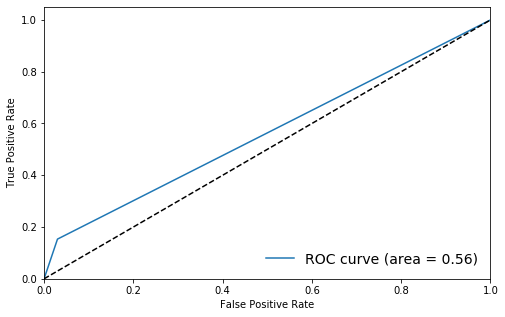

In [217]:
%matplotlib inline
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc_models_o_val[2]))
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate') 
plt.tick_params(axis='both', which='major')
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.show()

# Model evaluation on test set
il miglior modello è quello con la tecnica dell'undersampling, valutiamo il tutto sul test set

In [218]:
df_test = pd.read_csv('../../data/test.csv') 
cl_test.cleaning(df_test)
df_test.columns

Index(['IsBadBuy', 'Auction', 'VehicleAge', 'WheelTypeID', 'VehOdo', 'Size',
       'MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionRetailAveragePrice',
       'MMRCurrentAuctionAveragePrice', 'MMRCurrentRetailAveragePrice', 'VNST',
       'VehBCost', 'WarrantyCost'],
      dtype='object')

In [219]:
df_test = pd.get_dummies(df_test)
df_test = pd.get_dummies(df_test, columns=['WheelTypeID'])
df_test.columns

Index(['IsBadBuy', 'VehicleAge', 'VehOdo', 'MMRAcquisitionAuctionAveragePrice',
       'MMRAcquisitionRetailAveragePrice', 'MMRCurrentAuctionAveragePrice',
       'MMRCurrentRetailAveragePrice', 'VehBCost', 'WarrantyCost',
       'Auction_ADESA', 'Auction_MANHEIM', 'Auction_OTHER', 'Size_COMPACT',
       'Size_CROSSOVER', 'Size_LARGE', 'Size_LARGE SUV', 'Size_LARGE TRUCK',
       'Size_MEDIUM', 'Size_MEDIUM SUV', 'Size_SMALL SUV', 'Size_SMALL TRUCK',
       'Size_SPECIALTY', 'Size_SPORTS', 'Size_VAN', 'VNST_AL', 'VNST_AR',
       'VNST_AZ', 'VNST_CA', 'VNST_CO', 'VNST_FL', 'VNST_GA', 'VNST_IA',
       'VNST_ID', 'VNST_IL', 'VNST_IN', 'VNST_KY', 'VNST_LA', 'VNST_MA',
       'VNST_MD', 'VNST_MI', 'VNST_MN', 'VNST_MO', 'VNST_MS', 'VNST_NC',
       'VNST_NE', 'VNST_NH', 'VNST_NJ', 'VNST_NM', 'VNST_NV', 'VNST_NY',
       'VNST_OH', 'VNST_OK', 'VNST_OR', 'VNST_PA', 'VNST_SC', 'VNST_TN',
       'VNST_TX', 'VNST_UT', 'VNST_VA', 'VNST_WA', 'VNST_WV',
       'WheelTypeID_1.0', 'WheelTypeID_2.0',

In [222]:
attributes = [col for col in df_test.columns if col != 'IsBadBuy']
x_test = df_test[attributes].values
y_test = df_test['IsBadBuy']

In [223]:
y_pred_test = models_u[0].predict(x_test)

Test Accuracy 0.5678953137845986
Test F1-score [0.69274614 0.27212926]
              precision    recall  f1-score   support

           0       0.92      0.55      0.69     12828
           1       0.17      0.67      0.27      1768

    accuracy                           0.57     14596
   macro avg       0.55      0.61      0.48     14596
weighted avg       0.83      0.57      0.64     14596

Confusion matrix, without normalization
[[6433 6395]
 [ 502 1266]]
Normalized confusion matrix
[[0.50148114 0.49851886]
 [0.28393665 0.71606335]]


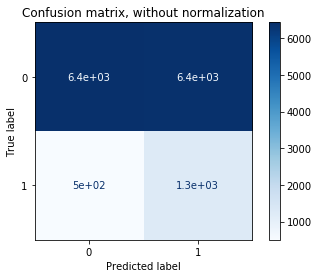

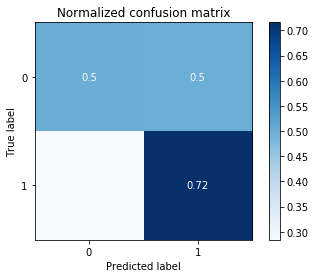

In [224]:
print('Test Accuracy %s' % accuracy_score(y_test, y_pred_test))
print('Test F1-score %s' % f1_score(y_test, y_pred_test, average=None))
print(classification_report(y_test, y_pred_test))

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(models[0], x_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)
    print(title)
    print(disp.confusion_matrix)

plt.show()


In [225]:
fpr, tpr, _ = roc_curve(y_test, y_pred_test)
roc_auc = auc(fpr, tpr)
roc_auc = roc_auc_score(y_test, y_pred_test, average=None)
print("model {} - roc_auc: {}".format(0, roc_auc))
roc_auc_models.append(roc_auc)

model 0 - roc_auc: 0.6105557589661754


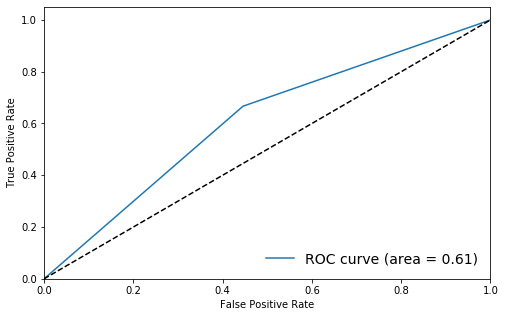

In [226]:
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate') 
plt.tick_params(axis='both', which='major')
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.show()